# Some imports and helper code

In [2]:
import os
import pickle
import seaborn
import numpy as np
import pandas as pd
import scipy as sci
import networkx as nx
import numpy.linalg as LIN
import matplotlib.pylab as plt
from utils import *
np.random.seed(1)

%matplotlib inline 
%load_ext autoreload

plt.style.use('seaborn-paper')
seaborn.set_context('paper', font_scale=2.2)
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.weight'] = 'medium'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation results of epidemic spreading

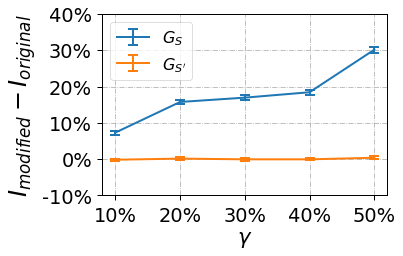

In [86]:
graph_type = 'Airport'
graph_weight = 'weighted'
mode = 'min_eigcent_SP'
GAMMA = 0.1
TAU = 0.9
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30


min_budget = {
    'Airport': 0.075,
    'Protein': 0.1247,
    'Email': 0.0063
}


with open('../result/{}/{}/{}-SIS/Gamma-{:.2f}---Tau-{:.2f}/{}_numExp_{}_SIS_equalAlpha.p'.format(\
                                                graph_weight, mode, graph_type, GAMMA, TAU, graph_type, numExp), 'rb') as fid:
    data = pickle.load(fid)
data = data[~(data['ratio targets'].isin([0]) & data['ratio bystanders'].isin([0]))]
data = data.dropna()


SP_err = []
Key = 'ratio bystanders'
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
    b.index = range(len(b))
    SP_err.append((a-b).sem() * 1.96)
    
S_err = []
Key = 'ratio targets'
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
    b.index = range(len(b))
    S_err.append((a-b).sem() * 1.96)
    
    
S_attacked = data.pivot_table(index=['graph', 'budget'])['ratio targets']['attacked']
S_original = data.pivot_table(index=['graph', 'budget'])['ratio targets']['original']

SP_attacked = data.pivot_table(index=['graph', 'budget'])['ratio bystanders']['attacked']
SP_original = data.pivot_table(index=['graph', 'budget'])['ratio bystanders']['original']

S_diff  = S_attacked - S_original
SP_diff = SP_attacked - SP_original

x = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.errorbar(x, S_diff, yerr=S_err, label='$G_S$', linewidth=2, markersize=7, capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(x, SP_diff, yerr=SP_err, label='$G_{S\'}$', linewidth=2, markersize=7, capsize=5, elinewidth=2, markeredgewidth=2)
plt.xticks(x, ['10%', '20%', '30%', '40%', '50%'])
# plt.axvline(x=min_budget[graph_type], linestyle='-.', color='r')
ax = plt.gca()
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.xlabel('$\gamma$')
plt.ylabel('$I_{modified} - I_{original}$', fontsize=24)
plt.legend(fontsize=16, loc='upper left')
plt.grid(linestyle='-.')
plt.tight_layout()
# plt.savefig('../result/figure/{}/{}_numExp_{}_{}_overall.pdf'.format(graph_weight, graph_type, numExp, graph_weight))

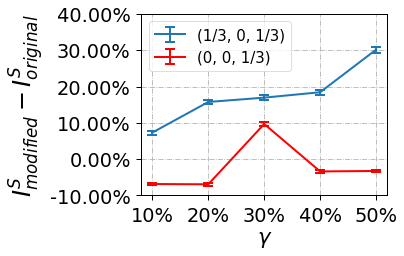

In [85]:
## Check if the normalized cut is really helpful in the long-run behavior

graph_type = 'Airport'
TARGET = '1st'
graph_weight = 'weighted'
mode = 'min_eigcent_SP'
GAMMA = 0.1
TAU = 0.9

numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
Key = 'ratio targets' if TARGET != '2nd' else 'ratio bystanders'
target_mapping = {
    '1st': ['equalAlpha', 'alpha3=1'],
    '2nd': ['equalAlpha', 'alpha2=0'],
    '3rd': ['equalAlpha', 'alpha3=0']
}
################################################################################################
## alpha_3 \ne 0
with open('../result/{}/{}/{}-SIS/Gamma-{:.2f}---Tau-{:.2f}/{}_numExp_{}_SIS_{}.p'.format(\
                                                graph_weight, mode, graph_type, GAMMA, TAU, graph_type, numExp, target_mapping[TARGET][0]), 'rb') as fid:
    data = pickle.load(fid)
data = data[~(data['ratio targets'].isin([0]) & data['ratio bystanders'].isin([0]))]
data = data.dropna()

S_err = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
    b.index = range(len(b))
    S_err.append((a-b).sem() * 1.96)
    
################################################################################################
## control experiments ##

with open('../result/{}/{}/{}-SIS/Gamma-{:.2f}---Tau-{:.2f}/{}_numExp_{}_SIS_{}.p'.format(\
                                                graph_weight, mode, graph_type, GAMMA, TAU, graph_type, numExp, target_mapping[TARGET][1]), 'rb') as fid:
    data_alpha3_zero = pickle.load(fid)
data_alpha3_zero = data_alpha3_zero[~(data_alpha3_zero['ratio targets'].isin([0]) & data_alpha3_zero['ratio bystanders'].isin([0]))]
data_alpha3_zero = data_alpha3_zero.dropna()
    
S_err_alpha3_zero = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data_alpha3_zero[data_alpha3_zero['graph'].isin(['attacked']) & data_alpha3_zero['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data_alpha3_zero[data_alpha3_zero['graph'].isin(['original']) & data_alpha3_zero['budget'].isin([budget])][Key]
    b.index = range(len(b))
    S_err_alpha3_zero.append((a-b).sem() * 1.96)
    
################################################################################################

S_attacked = data.pivot_table(index=['graph', 'budget'])[Key]['attacked']
S_original = data.pivot_table(index=['graph', 'budget'])[Key]['original']
S_diff  = S_attacked - S_original

S_attacked_control = data_alpha3_zero.pivot_table(index=['graph', 'budget'])[Key]['attacked']
S_original_control = data_alpha3_zero.pivot_table(index=['graph', 'budget'])[Key]['original']
S_diff_control = S_attacked_control - S_original_control


x = [0.1, 0.2, 0.3, 0.4, 0.5]
legend_mapping = {
    '1st': ['(1/3, 0, 1/3)', '(0, 0, 1/3)'],
    '2nd': ['(1/3, 1/3, 1/3)', '(1/3, 0, 1/3)'],
    '3rd': ['(1/3, 1/3, 1/3)', '(1/3, 1/3, 0)']
}
plt.errorbar(x, S_diff, yerr=S_err, label=legend_mapping[TARGET][0], linewidth=2, markersize=7, 
             capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(x, S_diff_control, yerr=S_err_alpha3_zero, label=legend_mapping[TARGET][1], linewidth=2, markersize=7, \
             capsize=5, elinewidth=2, markeredgewidth=2, color='r')
plt.xticks(x, ['10%', '20%', '30%', '40%', '50%'])
ax = plt.gca()
plt.yticks(ax.get_yticks(),  ['%.2f%%' % (i*100) for i in ax.get_yticks()])
plt.xlabel('$\gamma$')
if TARGET in ['1st', '3rd']:
    plt.ylabel('$I_{modified}^S - I_{original}^{S}$', fontsize=24)
else:
    plt.ylabel('$I_{modified}^{S\'} - I_{original}^{S\'}$', fontsize=24)
plt.legend(fontsize=15, loc='upper left')
plt.grid(linestyle='-.')
plt.tight_layout()
# plt.savefig('../result/figure/{}/{}_numExp_{}_controlExp_{}_{}.pdf'.format(graph_weight, graph_type, numExp, graph_weight, TARGET))

In [275]:
### the statisticas about the largest eigenvlaues of BTER networks ###
import seaborn
n = 375
ret = []
for i in range(30):
    G = nx.read_edgelist('../data/BTER_{:02d}.txt'.format(i), nodetype=int)
    adj = nx.adjacency_matrix(G).todense()
    lambda1 = LIN.eig(adj)[0].max()
    ret.append(np.real(lambda1))
print(np.min(ret))
print(np.max(ret))

14.415055658217216
16.57809155392885


In [162]:
### the density of S/S' as the attacker's budget increases ###

graph_type = 'Airport'
graph_weight = 'weighted'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
mode = 'min_eigcent_SP'
folder = '../result/{}/{}'.format(graph_weight, mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}_newcomm_4.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            S = [i for i in range(G.order()) if G.nodes[i]['target']]
            G_S = G.subgraph(S)
            ret.append((nx.density(G_S), gn, budget))
ret = pd.DataFrame(ret, columns=['S-density', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(len(S))

231


In [18]:
### the largest eigenvalue of G as the attacker's budget increases ###

graph_type = 'Small-World'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
graph_weight = 'unweighted'
mode = 'min_eigcent_SP'
folder = '../result/{}/{}'.format(graph_weight, mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}_newcomm.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            adj = nx.adjacency_matrix(G).todense()
            lambda1 = np.real(LIN.eig(adj)[0].max())
            
            S = [i for i in range(G.order()) if G.nodes[i]['target']]
            G_S = G.subgraph(S)
            adj_S = nx.adjacency_matrix(G_S).todense()
            lambda1_S = np.real(LIN.eig(adj_S)[0].max())
            
            SP = [i for i in range(G.order()) if not G.nodes[i]['target']]
            G_SP = G.subgraph(SP)
            adj_SP = nx.adjacency_matrix(G_SP).todense()
            lambda1_SP = np.real(LIN.eig(adj_SP)[0].max())
            
            ret.append((lambda1, lambda1_S, lambda1_SP, gn, budget))
ret = pd.DataFrame(ret, columns=['lambda1', 'lambda1_S', 'lambda1_SP', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(y)

                   lambda1  lambda1_S  lambda1_SP
graph    budget                                  
attacked 0.1     10.231825   8.378253    9.891288
         0.2     10.294785   9.022473    9.893836
         0.3     10.389864   9.328290    9.892418
         0.4     10.839431  10.048028    9.834265
         0.5     11.239151  10.697832    9.877519
original 0.1     10.219837   8.226531    9.891288
         0.2     10.215454   8.318042    9.893836
         0.3     10.215891   8.295363    9.892418
         0.4     10.227133   8.470585    9.834265
         0.5     10.220342   8.443774    9.877519


In [1459]:
(len(S) / np.sqrt(len(G))) * 0.1 / 7.6266

0.006263568516427524

In [1111]:
### the cut (non-normalized) size as the attacker's budget increases ###

graph_type = 'Airport'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
graph_weight = 'weighted'
mode = 'min_eigcent_SP'
folder = '../result/{}/{}'.format(graph_weight, mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            S = [i for i in range(G.order()) if G.nodes[i]['target']]
            if graph_weight == 'weighted':
                ret.append((nx.cut_size(G, S, weight='weight'), gn, budget))
            else:
                ret.append((nx.cut_size(G, S), gn, budget))
ret = pd.DataFrame(ret, columns=['cut size', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(y)

                  cut size
graph    budget           
attacked 0.1     80.817436
         0.2     80.414661
         0.3     80.358315
         0.4     80.487387
         0.5     80.682620
original 0.1     81.688967
         0.2     81.688967
         0.3     81.688967
         0.4     81.688967
         0.5     81.688967


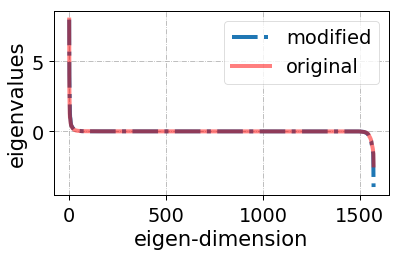

In [164]:
### the spectra before/after attack ###

graph_type = 'Airport'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
graph_weight = 'weighted'
mode = 'min_eigcent_SP'
folder = '../result/{}/{}'.format(graph_weight, mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']
budget = 0.5
exp = 0
# 1489618.0


with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)
    
ret = {'attacked': None, 'original': None}
for key, _ in ret.items():
    G = data[budget][exp][key]
    adj = nx.adjacency_matrix(G).todense() 
    eigVals = sorted(np.real(LIN.eig(adj)[0]), reverse=True)
    ret[key] = eigVals

x = range(len(G))
plt.plot(x, ret['attacked'], label='modified', linestyle='-.', linewidth=4)
plt.plot(x, ret['original'], label='original', linewidth=4, alpha=0.5, color='r')
plt.legend()
plt.grid(linestyle='-.')
plt.ylabel('eigenvalues')
plt.xlabel('eigen-dimension')
plt.tight_layout()
plt.savefig('../result/figure/{}/{}_{}_eigen.pdf'.format(graph_weight, graph_type, Key))

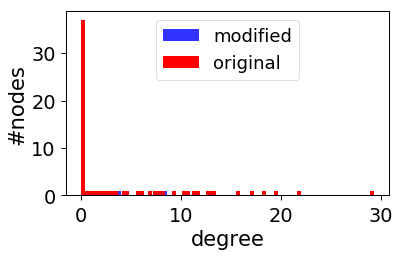

In [171]:
### the degree distributioin before/after attack ###
import collections

graph_type = 'Airport'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
mode = 'min_eigcent_SP'
graph_weight = 'weighted'
folder = '../result/{}/{}'.format(graph_weight, mode)
Key = 'equalAlpha'
graph_name = ['attacked', 'original']
budget = 0.5
exp = 0 if graph_type in ['Email', 'Airport', 'Protein'] else 10
# 1489618.0


with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)
    
plt.figure(figsize=(6,4))
deg_dist = {'attacked': None, 'original': None}
for gn in graph_name:
    G = data[budget][exp][gn]
#     degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    deg_seq = nx.adjacency_matrix(G).todense() * np.matrix(np.ones((len(G), 1))) 
    deg_seq = [item[0, 0] for item in deg_seq]
    degree_sequence = sorted(deg_seq, reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
#     deg_dist[gn] = np.array(cnt) / np.sum(cnt)
    deg_dist[gn] = deg_seq
    if gn == 'attacked':
        plt.bar(deg, cnt, width=0.4, color='b', alpha=0.8, align='edge', label='modified')
    else:
        plt.bar(deg, cnt, width=0.4, color='r', align='edge', label='original')
plt.legend(loc='upper center', fontsize=18)
plt.ylabel('#nodes')
plt.xlabel('degree')
plt.tight_layout()
plt.savefig('../result/figure/{}/{}_{}_deg.pdf'.format(graph_weight, graph_type, Key))

In [1522]:
sci.stats.ttest_ind(deg_dist['attacked'], deg_dist['original'])

Ttest_indResult(statistic=1.7410092550826766, pvalue=0.08183807116794836)

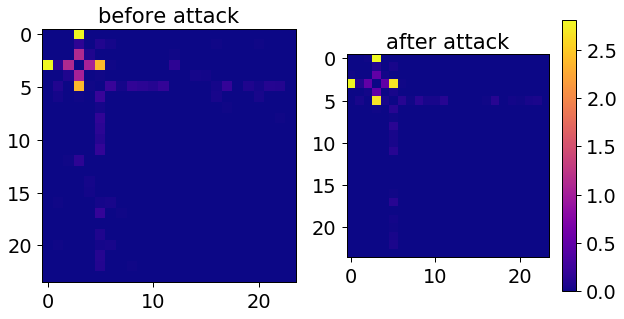

In [38]:
## visualize the adjacency matrix before and after the attack
    
def plot_adj_matrices(A, attacked_A):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    p0 = axes[0].imshow(A, cmap='plasma')
    axes[0].set_title('before attack')
#     fig.colorbar(p0, ax=axes[0])
    p1 = axes[1].imshow(attacked_A, cmap='plasma')
    im = axes[1].set_title('after attack')
    fig.colorbar(p1, ax=axes[1])

#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, ax=cbar_ax)
    
graph_type = 'Airport'
graph_weight = 'weighted'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
exp = 0 if graph_type in ['Email', 'Airport'] else 10
Key = 'equalAlpha'
budget = 0.5

with open('../result/{}/min_eigcent_SP/{}_numExp_{}_ret_{}.p'.format(graph_weight, graph_type, numExp, Key), 'rb') as fid:
    data = pickle.load(fid)
Attacker = data[budget][0][-1]

A_attacked = Attacker.get_attacked_adj() 
A = Attacker.original_adj 

# A_attacked /= A_attacked.max()
# A  /= A.max()

S_attacked = get_submatrix(A_attacked, Attacker.S, Attacker.S)
S = get_submatrix(A, Attacker.S, Attacker.S)

bound_attacked = get_submatrix(A_attacked, Attacker.S, Attacker.S_prime)
bound  = get_submatrix(A, Attacker.S, Attacker.S_prime)

# new_idx = torch.cat((Attacker.S, Attacker.S_prime)).numpy()
new_idx = Attacker.S.numpy()
plot_adj_matrices(A.numpy()[np.ix_(new_idx, new_idx)], A_attacked.numpy()[np.ix_(new_idx, new_idx)])

In [39]:
v2 = torch.symeig(0.06 * A_attacked + (1 - 0.24) * torch.eye(len(A_attacked)))[0][-2].numpy()
np.log(len(A_attacked)) / v2

7.358885476198452

In [948]:
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman

G = nx.read_edgelist('../data/US-airport.txt', nodetype=int, data=(('weight',float),) )
comps = nx.connected_components(G)
comp_max_idx = max(comps, key=lambda x: len(x))
G = G.subgraph(comp_max_idx)
mapping = {item: idx for idx, item in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
# Adj = nx.adjacency_matrix(G).todense() 
# Adj /= Adj.max()
# G = nx.from_numpy_matrix(Adj)

In [949]:
nx.adjacency_matrix(G).todense().max()

1489618.0

In [79]:
### average degree and local clustering coeff.

graph_type = 'BTER'
numExp = 1 if graph_type in ['Email', 'Airport', 'Protein'] else 30
graph_weight = 'unweighted'
Key = 'equalAlpha'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            avg_deg = np.mean([G.degree(i) for i in range(G.order())])
            loc_cluster = nx.average_clustering(G)
            density = nx.density(G)
            ret.append((avg_deg, loc_cluster, density, gn, budget))
ret = pd.DataFrame(ret, columns=['avg. degree', 'loc. cluster', 'density', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(y)

                 avg. degree  loc. cluster   density
graph    budget                                     
attacked 0.1       11.508176      0.047230  0.032313
         0.2       11.538843      0.047947  0.032399
         0.3       11.580515      0.049023  0.032516
         0.4       11.652395      0.050743  0.032718
         0.5       11.751169      0.052887  0.032995
original 0.1       11.498115      0.047017  0.032284
         0.2       11.498115      0.047017  0.032284
         0.3       11.498115      0.047017  0.032284
         0.4       11.498115      0.047017  0.032284
         0.5       11.498115      0.047017  0.032284


In [1084]:
graph_type = 'Airport'
graph_weight = 'weighted'
numExp = 1 if graph_type in ['Email', 'Airport'] else 30
exp = 0 if graph_type in ['Email', 'Airport'] else 10
Key = 'equalAlpha'
budget = 0.5
with open('../result/{}/min_eigcent_SP/{}_numExp_{}_attacked_graphs_{}.p'.format(graph_weight, graph_type, numExp, Key), 'rb') as fid:
    data = pickle.load(fid)

In [1085]:
G = data[0.5][0]['original']
G_attacked = data[0.5][0]['attacked']

In [1089]:
G[0][1]

{'weight': 6.041817432388706e-06}

In [1090]:
G_attacked[0][1]

{'weight': 5.393522769736592e-06}